In [1]:
from simulation_utils import * 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gpboost as gpb
import pdpbox
from pdpbox import pdp
sns.set()

### Small data setting: Linear function with shared GP

In [2]:
# Generate data
n, m = 500, 50  # Number of observations and groups
p = int(n/m) # Number of observations per group
data, X, y, F = generate_data(n, m, p, func='linear_func', random_state=60, shared_gp=True)

# Create groups
groups = np.arange(n)
for i in range(m):
    groups[i*p:(i+1)*p] = i

# Create times for validation datasets
times = np.tile(np.arange(p)*10+10, m)

In [3]:
data

,group,times,feature_1,feature_2,feature_3,feature_4,y
0,0,26,0.300873,0.186946,0.323183,0.665750,2.509764
1,0,54,0.566971,0.398254,0.379415,0.010582,3.008419
2,0,172,0.170366,0.123393,0.692401,0.874442,5.743980
3,0,321,0.337397,0.992459,0.131540,0.500330,3.267110
4,0,390,0.286621,0.220585,0.502086,0.636063,0.838914
...,...,...,...,...,...,...,...
495,49,630,0.349987,0.306533,0.985620,0.463537,1.732312
496,49,822,0.954944,0.681954,0.888071,0.202472,7.727281
497,49,831,0.217244,0.298916,0.905928,0.333855,3.910626
498,49,857,0.679392,0.080743,0.509631,0.417974,4.359974


In [4]:
group_sizes = X.groupby(['group']).size().to_numpy()
X_train, X_test, y_train, y_test, F_train, F_test = train_test_split_grouped_interpolation(X, y, F, group_sizes, test_size=0.2, random_state=1)

In [5]:
X_train

,group,times,feature_1,feature_2,feature_3,feature_4
0,0,26,0.300873,0.186946,0.323183,0.665750
1,0,54,0.566971,0.398254,0.379415,0.010582
2,0,172,0.170366,0.123393,0.692401,0.874442
3,0,321,0.337397,0.992459,0.131540,0.500330
4,0,390,0.286621,0.220585,0.502086,0.636063
...,...,...,...,...,...,...
494,49,609,0.133895,0.255245,0.593317,0.428608
495,49,630,0.349987,0.306533,0.985620,0.463537
496,49,822,0.954944,0.681954,0.888071,0.202472
497,49,831,0.217244,0.298916,0.905928,0.333855


## LME with Individual GP

In [6]:
np.random.seed(1)
X_train_linear = np.column_stack((np.ones(len(X_train)), X_train[['feature_1','feature_2','feature_3','feature_4']]))
X_test1_linear = np.column_stack((np.ones(len(X_test)), X_test[['feature_1','feature_2','feature_3','feature_4']]))
#gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cluster_ids=X_train['group'])
#gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

gp_model = gpb.GPModel(group_data=X_train['group'].values, gp_coords=X_train['times'].values, cluster_ids=X_train['group'].values, cov_function='matern', cov_fct_shape=2.5)
gp_model.fit(y=y_train, X=X_train_linear)
#preds = gp_model.predict(group_data_pred=X_test['group'].values, gp_coords_pred=X_test['times'].values, cluster_ids_pred=X_test['group'].values, X_pred=X_test1_linear, predict_var=True)

In [7]:
X_test.groupby(['group']).size().to_numpy()

array([2, 6, 1, 1, 1, 9, 3, 7, 1, 5, 1, 6, 2, 1, 2, 1, 1, 1, 1, 1, 9, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [8]:
specific_group = data[data['group'] == 6] # pick a group with 3 observations in the interpolation test set
y_true = specific_group['y'].to_numpy()
specific_test_linear = np.column_stack((np.ones(len(specific_group)), specific_group[['feature_1','feature_2','feature_3','feature_4']]))
preds = gp_model.predict(group_data_pred=specific_group['group'].values, gp_coords_pred=specific_group['times'].values, cluster_ids_pred=specific_group['group'].values, X_pred=specific_test_linear, predict_var=True)

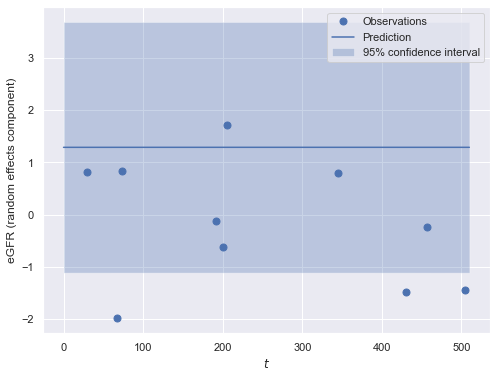

In [9]:
points = np.arange(specific_group['times'].iloc[-1]+10, step=10)
p = np.tile(specific_group['group'].iloc[0], len(points))
predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, X_pred=np.zeros((len(points), specific_test_linear.shape[1])), predict_var=True)
sigma = np.sqrt(predictions_points['var'])

plt.figure(figsize=(8,6))
plt.plot(specific_group['times'], y_true-preds['mu'], 'o', markersize=7, label='Observations')
plt.plot(points, predictions_points['mu'], 'b-', label='Prediction')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                 predictions_points['mu'] + 1.96 * sigma, alpha=0.3,
                 fc='b', label='95% confidence interval')
plt.xlabel('$t$')
plt.ylabel('eGFR (random effects component)')
plt.legend(loc='upper right')
plt.show()

## GPBoost with Individual GP

In [10]:
np.random.seed(1)
data_train = gpb.Dataset(data=X_train[['feature_1','feature_2','feature_3','feature_4']], label=y_train)
gp_model = gpb.GPModel(group_data=X_train['group'], gp_coords=X_train['times'], cluster_ids=X_train['group'])
gp_model.set_optim_params(params={'optimizer_cov': 'gradient_descent', 'use_nesterov_acc': True})

params = {'learning_rate': 0.1,
          'max_depth': 1,
          'min_data_in_leaf': 50,
          'objective': 'regression_l2',
          'verbose': 0,
          'num_leaves': 2**10}

bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=208)

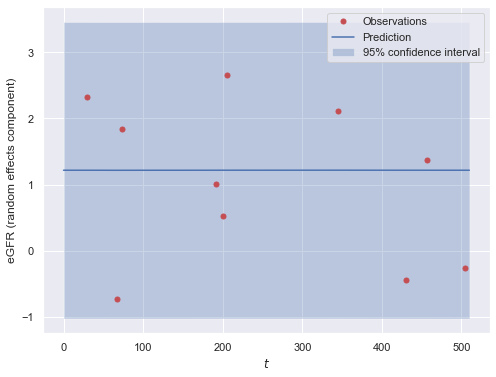

In [11]:
specific_group = data[data['group'] == 6] # pick a group with 3 observations in the interpolation test set
y_true = specific_group['y'].to_numpy()
preds = bst.predict(data=specific_group.drop(columns=['y', 'group', 'times']), 
                          group_data_pred=specific_group['group'],
                          gp_coords_pred=specific_group['times'],
                          cluster_ids_pred=specific_group['group'],
                          predict_var=True, pred_latent=True)

points = np.arange(specific_group['times'].iloc[-1]+10, step=10)
p = np.tile(specific_group['group'].iloc[0], len(points))
predictions_points = gp_model.predict(group_data_pred=p, gp_coords_pred=points, cluster_ids_pred=p, predict_var=True)
sigma = np.sqrt(predictions_points['var'])
plt.figure(figsize=(8,6))
plt.plot(specific_group['times'], y_true-preds['fixed_effect'], 'r.', markersize=10, label='Observations')
plt.plot(points, predictions_points['mu'], 'b-', label='Prediction')
plt.fill_between(points, predictions_points['mu'] - 1.96 * sigma,
                 predictions_points['mu'] + 1.96 * sigma, alpha=0.3,
                 fc='b', label='95% confidence interval')
plt.xlabel('$t$')
plt.ylabel('eGFR (random effects component)')
plt.legend(loc='upper right')
plt.show()

In [12]:
preds

{'fixed_effect': array([5.54117262, 3.65672933, 3.90754756, 6.60761763, 4.47263926,
        5.3540955 , 5.67759155, 6.22793031, 3.57252142, 4.33492707]),
 'random_effect_mean': array([1.21658121, 1.21580428, 1.21593057, 1.21669122, 1.21680191,
        1.2169703 , 1.21729203, 1.21669255, 1.21659302, 1.21647499]),
 'random_effect_cov': array([1.31090572, 1.31074207, 1.31073961, 1.31066003, 1.31064788,
        1.31067239, 1.31121199, 1.31151794, 1.31156867, 1.31162881]),
 'response_mean': None,
 'response_var': None}